# Difference

0
200000
400000
600000
800000
0.11539241079435801
EPSILON GREEDY POLICY MINIMUM: None
0
200000
400000
600000
800000
0.03243660820798358
BOLTZMANN POLICY MINIMUM: None
0
200000
400000
600000
800000
0.03689857627528441
UNIFORM POLICY MINIMUM: None
--- 186.86210107803345 seconds ---


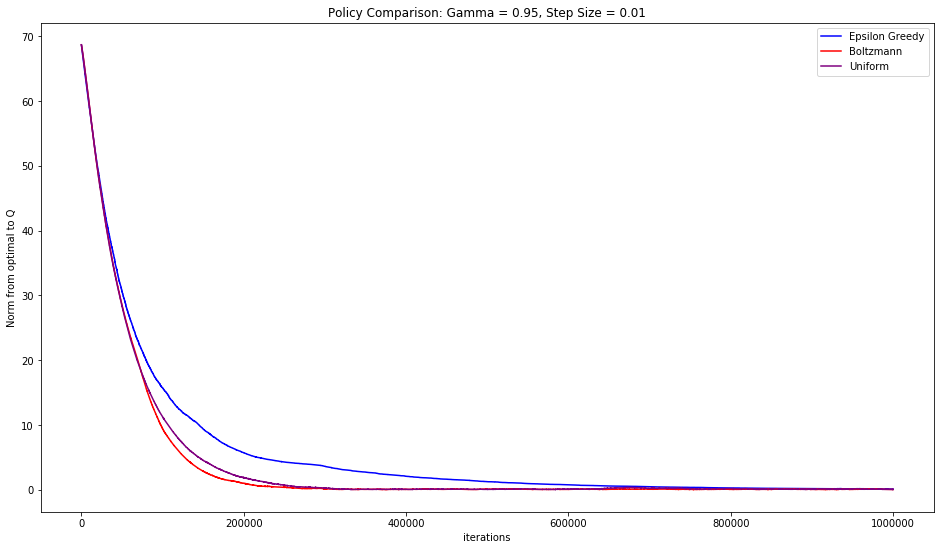

In [14]:
#initialized with random values:
#When initialized with random values it does not converge all the time, but a fair amount of the time

import gym
import numpy as np
import math
import matplotlib.pyplot as plt
from collections import deque
from queue import Queue
import random
#env= MarkovDP(10,3)      #Define an MDP Environment : Insantiate Class
#env.initialize_mdp()    #Define P and R
import mdptoolbox.example
import numpy as np
import sys
import time
import time
import timeit
import warnings
warnings.filterwarnings('ignore')
'''
Class MarkovDP contains the following attributes:
1)Number of states  : s
2)Number of actions : a
3)State Space
4)Action Space
5)Transition probability matrix of size (a,s,s)
6)Reward matrix (a,s,s)
'''
class MarkovDP:
    def __init__(self,s,a):
        self.num_state             = s
        self.num_action            = a
        self.states                = np.array(range(0,s))
        self.actions               = np.array(range(0,a))
        self.transitions           = np.zeros((a,s,s))
        self.rewards               = np.zeros((a,s,s))
        #print(rewards)
        
# The function below initializes transition probability matrix and rewards marks 

    def initialize_mdp(self):      
        np.random.seed(0)        #for reproducibility 
        self.transitions, self.rewards         = mdptoolbox.example.rand(self.num_state,self.num_action)
        self.rewards                           = np.random.rand(self.num_action, self.num_state) #, self.num_state) #,self.num_state)
        #print(self.rewards)

        
#having a min epsilon of 0.1 makes sure that no matter what there is some exploration so that if the epsilon decays too fast the enviornment is not dependent on its previous knowledge
class Qlearning(MarkovDP):
    def __init__(self, env, max_episodes = 1000000, printMod = 200000, max_steps = 1, min_epsilon= 0.1, epsilon = 1.00, gamma = 0.95, step = 0.01, tau = 100000, tau_decay = True, decay_factor_tau = 1.5):   #max_env_steps=None
        self.max_episodes = max_episodes # number of training episodes 
        self.max_steps = max_steps # average ticks over 100 episodes required for win
        self.alpha = 1.0 # learning rate parameter
        self.beta = 0.5 # learning rate parameter
        self.epsilon = epsilon # exploration rate
        self.min_epsilon = min_epsilon 
        self.gamma = gamma
        self.step = step
        self.printMod =  printMod
        self.env = env #gym.make('CartPole-v0')
        self.num_state = self.env.num_state
        self.num_action = self.env.num_action
        self.states = self.env.states
        self.actions = self.env.actions
        self.transitions = self.env.transitions
        self.rewards = self.env.rewards
        self.QTable = np.ones((env.num_state, env.num_action))
        self.zeros = np.full((10,3), 0)
        self.QFunction = np.array([[13.23176522, 13.33925622, 14.05469772], [13.52671959, 13.1224803,  13.22367197], [13.30159516, 13.86810447, 13.51346527], [13.66552722, 13.47151662, 13.23704243], [14.00228974, 13.41027839, 13.44004462], [13.42221627, 13.84567785, 13.56730379], [13.17987508, 13.49701082, 13.59308849], [13.24370111, 13.86450877, 13.89669707], [13.86681663, 13.87073118, 13.73493382], [13.24989143, 13.5198381,  13.37349781]])        
        self.tau = tau    # tau --> 0 pure exploitation tau --> infinity pure exploration
        self.tau_decay = tau_decay
        self.decay_factor_tau = decay_factor_tau          

    def epsilon_action(self, state, epsilon):
        ''' choose an action using the epsilon policy '''
        if np.random.random() <= epsilon:
            #print(self.env.actions)
            action = random.choice(self.env.actions)
            action = list(self.env.actions).index(action)
        else:
            action = np.argmax(self.QTable[state])  # exploitation
        return action
    
    def boltzmann_action(self, state, tau):
        qList = self.QTable[state] #moves = self.q_matrix[pos_index]
        self.actions = [i for i in range(0, self.env.num_action)]
        # Circumvent math issues with temperature actually being 0
        if self.tau > 0.0:
            #print(self.tau)
            # Compute action probabilities using tau; when
            # tau is high, we're treating values of very different
            # Q-values as more equally choosable
            action_probs_numes = []
            denom = 0
            for q in qList:
                val = math.exp(q / self.tau)
                action_probs_numes.append(val)
                denom += val  # summation of the values
            action_probs = []
            for x in action_probs_numes:
                probs = x / denom 
                action_probs.append(probs)    
            # Pick random move, in which moves with higher probability are
            # more likely to be chosen, but it is obviously not guaranteed
            prob_sum = 0
            action = random.choices(self.actions, weights=action_probs, k=1)[0] # the weights give a weight to correspond 
            #for each action , and then chooses a random action with each action weighted by it prob. and then chooses
            #I attemped using the action for the max probabilty but it only returned one action each time
        else:
            # Here, we're totally cold; meaning, we're just exploiting
            action = np.argmax(self.QTable[state])
        return action
    
    def uniform_action(self, state):
        ''' choose an action using the epsilon policy '''
        action = random.choice(self.env.actions)
        action = list(self.env.actions).index(action)
        return action

    def Q_Update(self, state, action, reward, new_state, step_size):
        ''' Update the Q-values'''
        self.QTable[state][action] += step_size * (reward + self.gamma * (np.max(self.QTable[new_state])) - self.QTable[state][action])
        
    def decay_epsilon(self):
        epsilon = self.epsilon * 0.99
        if epsilon < self.min_epsilon:
            self.epsilon = self.min_epsilon
        else:
            self.epsilon = epsilon
        return epsilon 
    
    def decay_step_size(self, t):
        if t == 0:
            step_size = 1.0
        elif t > 0:
            step_size = self.alpha / (t ** self.beta)  
        return step_size
    
    def decay_tau(self, t):          
        if self.tau_decay is True:
            #print(t)
            new_tau = self.tau - self.decay_factor_tau
        if new_tau < 1.0:
            self.tau = 1.0
        else:
            self.tau = new_tau
        return new_tau 

def epsilon_learning(Qlearning): #, max_episodes = 400, gamma = 0.95):
    QList = []
    QLog = []
    state = np.random.randint(0, Qlearning.num_state)
    tt=0
    r = 0
    q = 0
    for e in range(Qlearning.max_episodes):  
        if e % Qlearning.printMod == 0:
            print(e)
        epsilon = Qlearning.decay_epsilon() #e)
        step_size = Qlearning.step #self.decay_step_size(e)
        action = Qlearning.epsilon_action(state, epsilon)
        transitionVector = Qlearning.transitions[action][state]
        new_state = random.choices(population=Qlearning.states, weights=list(transitionVector))
        new_state = new_state[0]
        reward = Qlearning.rewards[action][state]
        Qlearning.Q_Update(state, action, reward, new_state, step_size)
        state = new_state
        QList.append(np.linalg.norm(Qlearning.QTable - Qlearning.QFunction))
    return QList

def boltzmann_learning(Qlearning): #, max_episodes = 400, min_epsilon=0.1, epsilon = 1.0, gamma = 0.95):
    #rewards = []
    #alphaList = []
    #epsilonList = []
    QList = []
    QLog = []
    state = np.random.randint(0, Qlearning.num_state)
    tt=0
    r = 0
    q = 0
    for e in range(Qlearning.max_episodes):  
        if e % Qlearning.printMod == 0:
            print(e)
        tau = Qlearning.decay_tau(e)
        step_size = Qlearning.step #0.01 #self.decay_step_size(e)
        action = Qlearning.boltzmann_action(state, tau)
        transitionVector = Qlearning.transitions[action][state]
        new_state = random.choices(population=Qlearning.states, weights=list(transitionVector))
        new_state = new_state[0]
        reward = Qlearning.rewards[action][state]
        Qlearning.Q_Update(state, action, reward, new_state, step_size)
        state = new_state
        QList.append(np.linalg.norm(Qlearning.QTable - Qlearning.QFunction))
        #QLog.append(math.log10(np.linalg.norm(self.QTable - self.QFunction)))
        #print(self.QTable)
    return QList
    
def uniform_learning(Qlearning): #, max_episodes = 400, gamma = 0.95):
    #rewards = []
    #alphaList = []
    #epsilonList = []
    QList = []
    QLog = []
    state = np.random.randint(0, Qlearning.num_state)
    tt=0
    r = 0
    q = 0
    for e in range(Qlearning.max_episodes):  
        if e % Qlearning.printMod == 0:
            print(e)
        #tau = Qlearning.decay_tau() #e)
        step_size = Qlearning.step #self.decay_step_size(e)
        action = Qlearning.uniform_action(state)
        transitionVector = Qlearning.transitions[action][state]
        new_state = random.choices(population= Qlearning.states, weights=list(transitionVector))
        new_state = new_state[0]
        reward = Qlearning.rewards[action][state]
        Qlearning.Q_Update(state, action, reward, new_state, step_size)
        state = new_state
        QList.append(np.linalg.norm(Qlearning.QTable - Qlearning.QFunction))
        #QLog.append(math.log10(np.linalg.norm(self.QTable - self.QFunction)))
        #print(self.QTable)
    return QList
    

if __name__ == '__main__':
    ''' Run main program. '''
    #main()
    #env= MarkovDP(10,3)      #Define an MDP Environment : Insantiate Class
    #env.initialize_mdp()    #Define P and R
    start_time = time.time()
    env = MarkovDP(10,3)
    env.initialize_mdp()
    solve = Qlearning(env) #MarkovDP)
    EG = epsilon_learning(solve)
    print("EPSILON GREEDY POLICY MINIMUM:", min(EG))
    solve = Qlearning(env)
    BP = boltzmann_learning(solve)
    print("BOLTZMANN POLICY MINIMUM:", min(BP))
    solve = Qlearning(env)
    UP = uniform_learning(solve)
    print("UNIFORM POLICY MINIMUM:", min(UP))
    #QList, QLog = solve.learning()
    print("--- %s seconds ---" % (time.time() - start_time))
    fig = plt.figure(figsize=(16,9))
    plt1 = fig.add_subplot(111)
    plt1.plot(EG,  # epsilon_hist,
             color='b',
             label='Epsilon Greedy')
    plt1.plot(BP,  # epsilon_hist,
             color='r',
             label='Boltzmann')
    plt1.plot(UP,  # epsilon_hist,
             color='purple',
             label='Uniform')
    plt1.set(title='Policy Comparison: Gamma = 0.95, Step Size = 0.01', 
            ylabel='Norm from optimal to Q',
            xlabel='iterations')
    fig.subplots_adjust(hspace=0.7)
    #ax1.legend(loc='best')
    plt1.legend(loc='best')
    #ax3.legend(loc='best')

    plt.show()

# Log base 10

0
200000
400000
600000
800000
EPSILON GREEDY POLICY MINIMUM: -0.7831424271668209
0
200000
400000
600000
800000
BOLTZMANN POLICY MINIMUM: -1.50714165135156
0
200000
400000
600000
800000
UNIFORM POLICY MINIMUM: -1.5046048634538407
--- 102.64359903335571 seconds ---


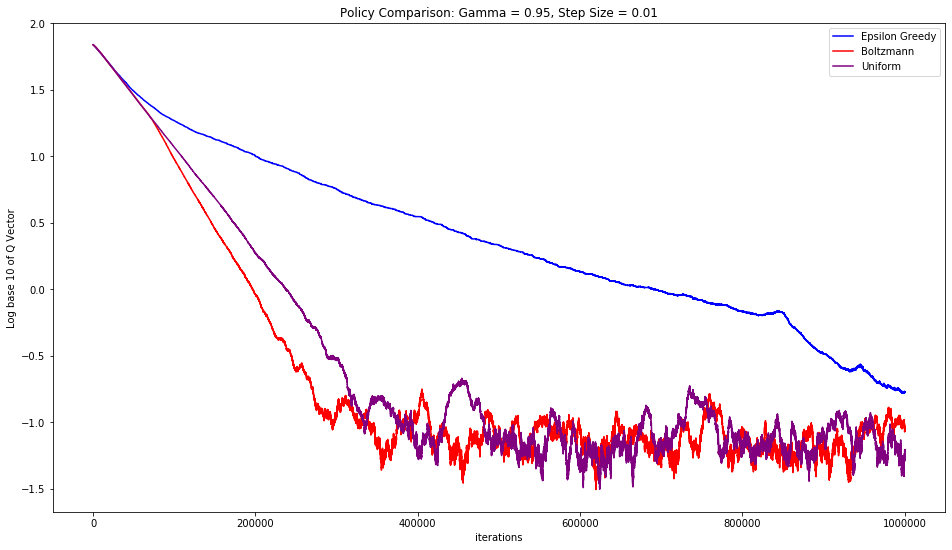

In [12]:
import numpy as np
import math
import matplotlib.pyplot as plt
from collections import deque
from queue import Queue
import random
import mdptoolbox.example
import numpy as np
import sys
import time
import time
import timeit
import warnings
warnings.filterwarnings('ignore')
'''
Class MarkovDP contains the following attributes:
1)Number of states  : s
2)Number of actions : a
3)State Space
4)Action Space
5)Transition probability matrix of size (a,s,s)
6)Reward matrix (a,s,s)
'''
class MarkovDP:
    def __init__(self,s,a):
        self.num_state             = s
        self.num_action            = a
        self.states                = np.array(range(0,s))
        self.actions               = np.array(range(0,a))
        self.transitions           = np.zeros((a,s,s))
        self.rewards               = np.zeros((a,s,s))
        #print(rewards)
        
# The function below initializes transition probability matrix and rewards marks 

    def initialize_mdp(self):      
        np.random.seed(0)        #for reproducibility 
        self.transitions, self.rewards         = mdptoolbox.example.rand(self.num_state,self.num_action)
        self.rewards                           = np.random.rand(self.num_action, self.num_state) #, self.num_state) #,self.num_state)
        #print(self.rewards)

        
#having a min epsilon of 0.1 makes sure that no matter what there is some exploration so that if the epsilon decays too fast the enviornment is not dependent on its previous knowledge
class Qlearning(MarkovDP):
    def __init__(self, env, max_episodes = 1000000, printMod = 200000, max_steps = 1, min_epsilon= 0.1, epsilon = 1.00, gamma = 0.95, step = 0.01, tau = 100000, tau_decay = True, decay_factor_tau = 1.5):   #max_env_steps=None
        self.max_episodes = max_episodes # number of training episodes 
        self.max_steps = max_steps # average ticks over 100 episodes required for win
        self.alpha = 1.0 # learning rate parameter
        self.beta = 0.5 # learning rate parameter
        self.epsilon = epsilon # exploration rate
        self.min_epsilon = min_epsilon 
        self.gamma = gamma
        self.step = step
        self.printMod =  printMod
        self.env = env #gym.make('CartPole-v0')
        self.num_state = self.env.num_state
        self.num_action = self.env.num_action
        self.states = self.env.states
        self.actions = self.env.actions
        self.transitions = self.env.transitions
        self.rewards = self.env.rewards
        self.QTable = np.ones((env.num_state, env.num_action))
        self.zeros = np.full((10,3), 0)
        self.QFunction = np.array([[13.23176522, 13.33925622, 14.05469772], [13.52671959, 13.1224803,  13.22367197], [13.30159516, 13.86810447, 13.51346527], [13.66552722, 13.47151662, 13.23704243], [14.00228974, 13.41027839, 13.44004462], [13.42221627, 13.84567785, 13.56730379], [13.17987508, 13.49701082, 13.59308849], [13.24370111, 13.86450877, 13.89669707], [13.86681663, 13.87073118, 13.73493382], [13.24989143, 13.5198381,  13.37349781]])        
        self.tau = tau    # tau --> 0 pure exploitation tau --> infinity pure exploration
        self.tau_decay = tau_decay
        self.decay_factor_tau = decay_factor_tau          

    def epsilon_action(self, state, epsilon):
        ''' choose an action using the epsilon policy '''
        if np.random.random() <= epsilon:
            action = random.choice(self.env.actions)
            action = list(self.env.actions).index(action)
        else:
            action = np.argmax(self.QTable[state])  # exploitation
        return action
    
    def boltzmann_action(self, state, tau):
        qList = self.QTable[state] #moves = self.q_matrix[pos_index]
        self.actions = [i for i in range(0, self.env.num_action)]
        # Circumvent math issues with temperature actually being 0
        if self.tau > 0.0:
            #print(self.tau)
            # Compute action probabilities using tau; when
            # tau is high, we're treating values of very different
            # Q-values as more equally choosable
            action_probs_numes = []
            denom = 0
            for q in qList:
                val = math.exp(q / self.tau)
                action_probs_numes.append(val)
                denom += val  # summation of the values
            action_probs = []
            for x in action_probs_numes:
                probs = x / denom 
                action_probs.append(probs)    
            # Pick random move, in which moves with higher probability are
            # more likely to be chosen, but it is obviously not guaranteed
            prob_sum = 0
            action = random.choices(self.actions, weights=action_probs, k=1)[0] # the weights give a weight to correspond 
            #for each action , and then chooses a random action with each action weighted by it prob. and then chooses
            #I attemped using the action for the max probabilty but it only returned one action each time
        else:
            # Here, we're totally cold; meaning, we're just exploiting
            action = np.argmax(self.QTable[state])
        return action
    
    def uniform_action(self, state):
        ''' choose an action using the epsilon policy '''
        action = random.choice(self.env.actions)
        action = list(self.env.actions).index(action)
        return action

    def Q_Update(self, state, action, reward, new_state, step_size):
        ''' Update the Q-values'''
        self.QTable[state][action] += step_size * (reward + self.gamma * (np.max(self.QTable[new_state])) - self.QTable[state][action])
        
    def decay_epsilon(self):
        epsilon = self.epsilon * 0.99
        if epsilon < self.min_epsilon:
            self.epsilon = self.min_epsilon
        else:
            self.epsilon = epsilon
        return epsilon 
    
    def decay_step_size(self, t):
        if t == 0:
            step_size = 1.0
        elif t > 0:
            step_size = self.alpha / (t ** self.beta)  
        return step_size
    
    def decay_tau(self, t):          
        if self.tau_decay is True:
            #print(t)
            new_tau = self.tau - self.decay_factor_tau
        if new_tau < 1.0:
            self.tau = 1.0
        else:
            self.tau = new_tau
        return new_tau 

def epsilon_learning(Qlearning): 
    QList = []
    QLog = []
    state = np.random.randint(0, Qlearning.num_state)
    tt=0
    r = 0
    q = 0
    for e in range(Qlearning.max_episodes):  
        if e % Qlearning.printMod == 0:
            print(e)
        epsilon = Qlearning.decay_epsilon() #e)
        step_size = Qlearning.step #self.decay_step_size(e)
        action = Qlearning.epsilon_action(state, epsilon)
        transitionVector = Qlearning.transitions[action][state]
        new_state = random.choices(population=Qlearning.states, weights=list(transitionVector))
        new_state = new_state[0]
        reward = Qlearning.rewards[action][state]
        Qlearning.Q_Update(state, action, reward, new_state, step_size)
        state = new_state
        QList.append((np.linalg.norm(Qlearning.QTable - Qlearning.QFunction)))
    for Q in QList:
        Ql = math.log10(Q)
        QLog.append(Ql)
    return QLog

def boltzmann_learning(Qlearning): 
    QList = []
    QLog = []
    state = np.random.randint(0, Qlearning.num_state)
    tt=0
    r = 0
    q = 0
    for e in range(Qlearning.max_episodes):  
        if e % Qlearning.printMod == 0:
            print(e)
        tau = Qlearning.decay_tau(e)
        step_size = Qlearning.step #0.01 #self.decay_step_size(e)
        action = Qlearning.boltzmann_action(state, tau)
        transitionVector = Qlearning.transitions[action][state]
        new_state = random.choices(population=Qlearning.states, weights=list(transitionVector))
        new_state = new_state[0]
        reward = Qlearning.rewards[action][state]
        Qlearning.Q_Update(state, action, reward, new_state, step_size)
        state = new_state
        QList.append((np.linalg.norm(Qlearning.QTable - Qlearning.QFunction)))
    for Q in QList:
        Ql = math.log10(Q)
        QLog.append(Ql)
    return QLog
    
def uniform_learning(Qlearning): 
    QList = []
    QLog = []
    state = np.random.randint(0, Qlearning.num_state)
    tt=0
    r = 0
    q = 0
    for e in range(Qlearning.max_episodes):  
        if e % Qlearning.printMod == 0:
            print(e)
        step_size = Qlearning.step #self.decay_step_size(e)
        action = Qlearning.uniform_action(state)
        transitionVector = Qlearning.transitions[action][state]
        new_state = random.choices(population= Qlearning.states, weights=list(transitionVector))
        new_state = new_state[0]
        reward = Qlearning.rewards[action][state]
        Qlearning.Q_Update(state, action, reward, new_state, step_size)
        state = new_state
        QList.append((np.linalg.norm(Qlearning.QTable - Qlearning.QFunction)))
    for Q in QList:
        Ql = math.log10(Q)
        QLog.append(Ql)
    return QLog
    

if __name__ == '__main__':
    ''' Run main program. '''
    #main()
    start_time = time.time()
    env = MarkovDP(10,3)
    env.initialize_mdp()
    solve = Qlearning(env) #MarkovDP)
    EG = epsilon_learning(solve)
    print("EPSILON GREEDY POLICY MINIMUM:", min(EG))
    solve = Qlearning(env)
    BP = boltzmann_learning(solve)
    print("BOLTZMANN POLICY MINIMUM:", min(BP))
    solve = Qlearning(env)
    UP = uniform_learning(solve)
    print("UNIFORM POLICY MINIMUM:", min(UP))
    #QList, QLog = solve.learning()
    print("--- %s seconds ---" % (time.time() - start_time))
    fig = plt.figure(figsize=(16,9))
    plt1 = fig.add_subplot(111)
    plt1.plot(EG,  # epsilon_hist,
             color='b',
             label='Epsilon Greedy')
    plt1.plot(BP,  # epsilon_hist,
             color='r',
             label='Boltzmann')
    plt1.plot(UP,  # epsilon_hist,
             color='purple',
             label='Uniform')
    plt1.set(title='Policy Comparison: Gamma = 0.95, Step Size = 0.01', 
             ylabel='Log base 10 of Q Vector',
             xlabel='iterations')
    fig.subplots_adjust(hspace=0.7)
    #ax1.legend(loc='best')
    plt1.legend(loc='best')
    #ax3.legend(loc='best')

    plt.show()

# Diminishing Step Size

0
500000
1000000
1500000
2000000
2500000
3000000
3500000
4000000
4500000
2.89163247833436
EPSILON GREEDY POLICY MINIMUM: None
0
500000
1000000
1500000
2000000
2500000
3000000
3500000
4000000
4500000
0.008574257402595384
BOLTZMANN POLICY MINIMUM: None
0
500000
1000000
1500000
2000000
2500000
3000000
3500000
4000000
4500000
0.011746702178264642
UNIFORM POLICY MINIMUM: None
--- 1004.4188461303711 seconds ---


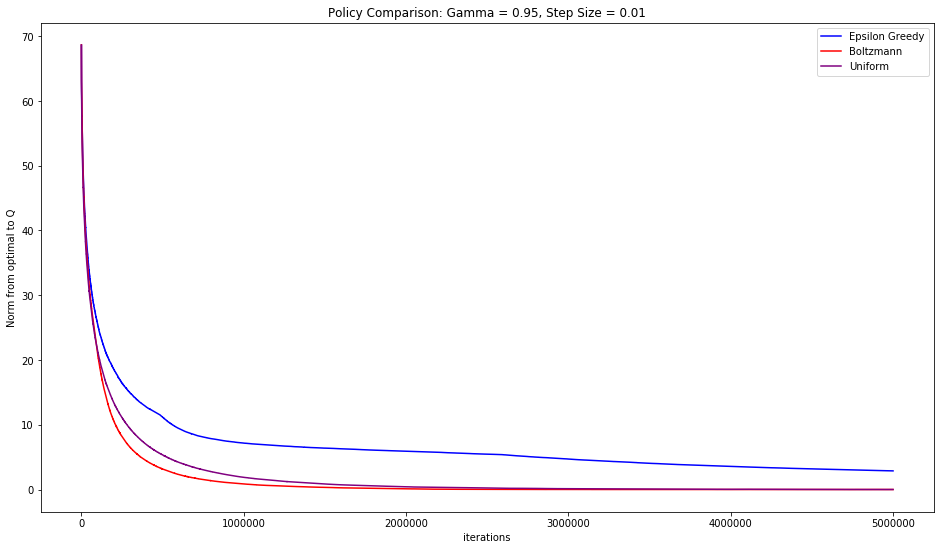

In [15]:
#initialized with random values:
#When initialized with random values it does not converge all the time, but a fair amount of the time

import gym
import numpy as np
import math
import matplotlib.pyplot as plt
from collections import deque
from queue import Queue
import random
#env= MarkovDP(10,3)      #Define an MDP Environment : Insantiate Class
#env.initialize_mdp()    #Define P and R
import mdptoolbox.example
import numpy as np
import sys
import time
import time
import timeit
import warnings
warnings.filterwarnings('ignore')
'''
Class MarkovDP contains the following attributes:
1)Number of states  : s
2)Number of actions : a
3)State Space
4)Action Space
5)Transition probability matrix of size (a,s,s)
6)Reward matrix (a,s,s)
'''
class MarkovDP:
    def __init__(self,s,a):
        self.num_state             = s
        self.num_action            = a
        self.states                = np.array(range(0,s))
        self.actions               = np.array(range(0,a))
        self.transitions           = np.zeros((a,s,s))
        self.rewards               = np.zeros((a,s,s))
        #print(rewards)
        
# The function below initializes transition probability matrix and rewards marks 

    def initialize_mdp(self):      
        np.random.seed(0)        #for reproducibility 
        self.transitions, self.rewards         = mdptoolbox.example.rand(self.num_state,self.num_action)
        self.rewards                           = np.random.rand(self.num_action, self.num_state) #, self.num_state) #,self.num_state)
        #print(self.rewards)

        
#having a min epsilon of 0.1 makes sure that no matter what there is some exploration so that if the epsilon decays too fast the enviornment is not dependent on its previous knowledge
class Qlearning(MarkovDP):
    def __init__(self, env, max_episodes = 5000000, printMod = 500000, max_steps = 1, min_epsilon= 0.1, epsilon = 1.00, gamma = 0.95, step = 0.01, tau = 100000, tau_decay = True, decay_factor_tau = 1.5):   #max_env_steps=None
        self.max_episodes = max_episodes # number of training episodes 
        self.max_steps = max_steps # average ticks over 100 episodes required for win
        self.alpha = 1.0 # learning rate parameter
        self.beta = 0.5 # learning rate parameter
        self.epsilon = epsilon # exploration rate
        self.min_epsilon = min_epsilon 
        self.gamma = gamma
        self.step = step
        self.printMod =  printMod
        self.env = env #gym.make('CartPole-v0')
        self.num_state = self.env.num_state
        self.num_action = self.env.num_action
        self.states = self.env.states
        self.actions = self.env.actions
        self.transitions = self.env.transitions
        self.rewards = self.env.rewards
        self.QTable = np.ones((env.num_state, env.num_action))
        self.zeros = np.full((10,3), 0)
        self.QFunction = np.array([[13.23176522, 13.33925622, 14.05469772], [13.52671959, 13.1224803,  13.22367197], [13.30159516, 13.86810447, 13.51346527], [13.66552722, 13.47151662, 13.23704243], [14.00228974, 13.41027839, 13.44004462], [13.42221627, 13.84567785, 13.56730379], [13.17987508, 13.49701082, 13.59308849], [13.24370111, 13.86450877, 13.89669707], [13.86681663, 13.87073118, 13.73493382], [13.24989143, 13.5198381,  13.37349781]])        
        self.tau = tau    # tau --> 0 pure exploitation tau --> infinity pure exploration
        self.tau_decay = tau_decay
        self.decay_factor_tau = decay_factor_tau          

    def epsilon_action(self, state, epsilon):
        ''' choose an action using the epsilon policy '''
        if np.random.random() <= epsilon:
            #print(self.env.actions)
            action = random.choice(self.env.actions)
            action = list(self.env.actions).index(action)
        else:
            action = np.argmax(self.QTable[state])  # exploitation
        return action
    
    def boltzmann_action(self, state, tau):
        qList = self.QTable[state] #moves = self.q_matrix[pos_index]
        self.actions = [i for i in range(0, self.env.num_action)]
        # Circumvent math issues with temperature actually being 0
        if self.tau > 0.0:
            #print(self.tau)
            # Compute action probabilities using tau; when
            # tau is high, we're treating values of very different
            # Q-values as more equally choosable
            action_probs_numes = []
            denom = 0
            for q in qList:
                val = math.exp(q / self.tau)
                action_probs_numes.append(val)
                denom += val  # summation of the values
            action_probs = []
            for x in action_probs_numes:
                probs = x / denom 
                action_probs.append(probs)    
            # Pick random move, in which moves with higher probability are
            # more likely to be chosen, but it is obviously not guaranteed
            prob_sum = 0
            action = random.choices(self.actions, weights=action_probs, k=1)[0] # the weights give a weight to correspond 
            #for each action , and then chooses a random action with each action weighted by it prob. and then chooses
            #I attemped using the action for the max probabilty but it only returned one action each time
        else:
            # Here, we're totally cold; meaning, we're just exploiting
            action = np.argmax(self.QTable[state])
        return action
    
    def uniform_action(self, state):
        ''' choose an action using the epsilon policy '''
        action = random.choice(self.env.actions)
        action = list(self.env.actions).index(action)
        return action

    def Q_Update(self, state, action, reward, new_state, step_size):
        ''' Update the Q-values'''
        self.QTable[state][action] += step_size * (reward + self.gamma * (np.max(self.QTable[new_state])) - self.QTable[state][action])
        
    def decay_epsilon(self):
        epsilon = self.epsilon * 0.99
        if epsilon < self.min_epsilon:
            self.epsilon = self.min_epsilon
        else:
            self.epsilon = epsilon
        return epsilon 
    
    def decay_step_size(self, t):
        if t == 0:
            step_size = 1.0
        elif t > 0:
            step_size = self.alpha / (t ** self.beta)  
        return step_size
    
    def decay_tau(self, t):          
        if self.tau_decay is True:
            #print(t)
            new_tau = self.tau - self.decay_factor_tau
        if new_tau < 1.0:
            self.tau = 1.0
        else:
            self.tau = new_tau
        return new_tau 

def epsilon_learning(Qlearning): #, max_episodes = 400, gamma = 0.95):
    #rewards = []
    #alphaList = []
    #epsilonList = []
    QList = []
    QLog = []
    state = np.random.randint(0, Qlearning.num_state)
    tt=0
    r = 0
    q = 0
    for e in range(Qlearning.max_episodes):  
        if e % Qlearning.printMod == 0:
            print(e)
        epsilon = Qlearning.decay_epsilon() #e)
        step_size = Qlearning.decay_step_size(e)
        action = Qlearning.epsilon_action(state, epsilon)
        transitionVector = Qlearning.transitions[action][state]
        new_state = random.choices(population=Qlearning.states, weights=list(transitionVector))
        new_state = new_state[0]
        reward = Qlearning.rewards[action][state]
        Qlearning.Q_Update(state, action, reward, new_state, step_size)
        state = new_state
        QList.append(np.linalg.norm(Qlearning.QTable - Qlearning.QFunction))
        #QLog.append(math.log10(np.linalg.norm(self.QTable - self.QFunction)))
        #print(self.QTable)
    return QList

def boltzmann_learning(Qlearning): #, max_episodes = 400, min_epsilon=0.1, epsilon = 1.0, gamma = 0.95):
    #rewards = []
    #alphaList = []
    #epsilonList = []
    QList = []
    QLog = []
    state = np.random.randint(0, Qlearning.num_state)
    tt=0
    r = 0
    q = 0
    for e in range(Qlearning.max_episodes):  
        if e % Qlearning.printMod == 0:
            print(e)
        tau = Qlearning.decay_tau(e)
        step_size = Qlearning.decay_step_size(e)
        action = Qlearning.boltzmann_action(state, tau)
        transitionVector = Qlearning.transitions[action][state]
        new_state = random.choices(population=Qlearning.states, weights=list(transitionVector))
        new_state = new_state[0]
        reward = Qlearning.rewards[action][state]
        Qlearning.Q_Update(state, action, reward, new_state, step_size)
        state = new_state
        QList.append(np.linalg.norm(Qlearning.QTable - Qlearning.QFunction))
        #QLog.append(math.log10(np.linalg.norm(self.QTable - self.QFunction)))
        #print(self.QTable)
    return QList
    
def uniform_learning(Qlearning): #, max_episodes = 400, gamma = 0.95):
    #rewards = []
    #alphaList = []
    #epsilonList = []
    QList = []
    QLog = []
    state = np.random.randint(0, Qlearning.num_state)
    tt=0
    r = 0
    q = 0
    for e in range(Qlearning.max_episodes):  
        if e % Qlearning.printMod == 0:
            print(e)
        #tau = Qlearning.decay_tau() #e)
        step_size = Qlearning.decay_step_size(e)
        action = Qlearning.uniform_action(state)
        transitionVector = Qlearning.transitions[action][state]
        new_state = random.choices(population= Qlearning.states, weights=list(transitionVector))
        new_state = new_state[0]
        reward = Qlearning.rewards[action][state]
        Qlearning.Q_Update(state, action, reward, new_state, step_size)
        state = new_state
        QList.append(np.linalg.norm(Qlearning.QTable - Qlearning.QFunction))
        #QLog.append(math.log10(np.linalg.norm(self.QTable - self.QFunction)))
        #print(self.QTable)
    return QList
    

if __name__ == '__main__':
    ''' Run main program. '''
    #main()
    #env= MarkovDP(10,3)      #Define an MDP Environment : Insantiate Class
    #env.initialize_mdp()    #Define P and R
    start_time = time.time()
    env = MarkovDP(10,3)
    env.initialize_mdp()
    solve = Qlearning(env) #MarkovDP)
    EG = epsilon_learning(solve)
    print("EPSILON GREEDY POLICY MINIMUM:", print(min(EG)))
    solve = Qlearning(env)
    BP = boltzmann_learning(solve)
    print("BOLTZMANN POLICY MINIMUM:", print(min(BP)))
    solve = Qlearning(env)
    UP = uniform_learning(solve)
    print("UNIFORM POLICY MINIMUM:", print(min(UP)))
    #QList, QLog = solve.learning()
    print("--- %s seconds ---" % (time.time() - start_time))
    fig = plt.figure(figsize=(16,9))
    plt1 = fig.add_subplot(111)
    plt1.plot(EG,  # epsilon_hist,
             color='b',
             label='Epsilon Greedy')
    plt1.plot(BP,  # epsilon_hist,
             color='r',
             label='Boltzmann')
    plt1.plot(UP,  # epsilon_hist,
             color='purple',
             label='Uniform')
    plt1.set(title='Policy Comparison: Gamma = 0.95, Step Size = 0.01', 
            ylabel='Norm from optimal to Q',
            xlabel='iterations')
    fig.subplots_adjust(hspace=0.7)
    #ax1.legend(loc='best')
    plt1.legend(loc='best')
    #ax3.legend(loc='best')

    plt.show()

# Synchronous

# Distance from optimal

0
10000
20000
30000
[[13.22527507 13.34721711 14.05744056]
 [13.52822402 13.11294316 13.22543276]
 [13.28793639 13.8592251  13.48449146]
 [13.66435977 13.45844067 13.22952054]
 [13.98639683 13.39165792 13.43457766]
 [13.42437277 13.81528241 13.55897481]
 [13.15680275 13.49513913 13.59495461]
 [13.24521473 13.8598864  13.89707968]
 [13.86931464 13.86704912 13.73166768]
 [13.22886605 13.51135105 13.35361228]]


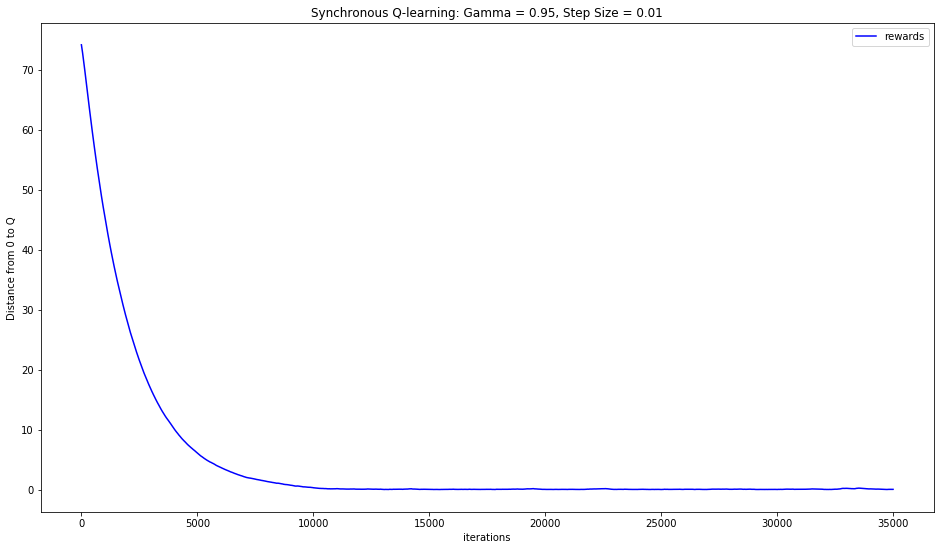

In [1]:
#initialized with random values:
#When initialized with random values it does not converge all the time, but a fair amount of the time

import gym
import numpy as np
import math
import matplotlib.pyplot as plt
from collections import deque
from queue import Queue
import random
#env= MarkovDP(10,3)      #Define an MDP Environment : Insantiate Class
#env.initialize_mdp()    #Define P and R
import mdptoolbox.example
import numpy as np
import sys
import time
import timeit
import warnings
warnings.filterwarnings('ignore')
'''
Class MarkovDP contains the following attributes:
1)Number of states  : s
2)Number of actions : a
3)State Space
4)Action Space
5)Transition probability matrix of size (a,s,s)
6)Reward matrix (a,s,s)
'''
class MarkovDP:
    def __init__(self,s,a):
        self.num_state             = s
        self.num_action            = a
        self.states                = np.array(range(0,s))
        self.actions               = np.array(range(0,a))
        self.transitions           = np.zeros((a,s,s))
        self.rewards               = np.zeros((a,s,s))
        
# The function below initializes transition probability matrix and rewards marks 

    def initialize_mdp(self):      
        np.random.seed(0)        #for reproducibility 
        self.transitions, self.rewards         = mdptoolbox.example.rand(self.num_state,self.num_action)
        #print(self.transitions)
        self.rewards                           = np.random.rand(self.num_action,self.num_state) #,self.num_state)
        #print(self.rewards)

        
#having a min epsilon of 0.1 makes sure that no matter what there is some exploration so that if the epsilon decays too fast the enviornment is not dependent on its previous knowledge
class Qlearning(MarkovDP):
    def __init__(self, env, max_episodes = 35000, max_steps = 1,min_alpha=0.1, min_epsilon=0.0, epsilon = 1.0, gamma = 0.95, decay = 25, solved=False):   #max_env_steps=None
        self.max_episodes = max_episodes # number of training episodes 
        self.max_steps = max_steps # average ticks over 100 episodes required for win
        self.alpha = 1.0 # learning rate parameter
        self.beta = 0.5 # learning rate parameter
        self.epsilon = epsilon # exploration rate
        self.min_alpha = min_alpha
        self.min_epsilon = min_epsilon 
        self.solved = solved
        self.gamma = gamma
        self.decay = decay  #works for most numbers between 5 and 35
        self.env = env #gym.make('CartPole-v0')
        self.QTable = np.zeros((env.num_state, env.num_action))
        self.zeros = np.full((10,3), 0)
        #self.rewards = np.array([[0.04292419, 0.33307203, 0.09973295, 0.47558912, 0.82002244, 0.29818736,0.1509349,  0.33026704, 0.81388014, 0.14038396], [0.22736245, 0.06885196, 0.70571004, 0.39523324, 0.31083998, 0.71862639, 0.33597754, 0.72777127, 0.8151994,  0.21766284], [0.9738187,  0.16235795, 0.29084091, 0.17979529, 0.34550566, 0.48006089, 0.52217587, 0.85360604, 0.88944791, 0.22010386]])
        #self.QFunction = np.array([[33.95194609, 34.05860066, 34.77345539], [34.24835596, 33.84102827, 33.94270157], [34.02202821, 34.58894248, 34.23688255], [34.38667542, 34.19158544, 33.95619866], [34.72368381, 34.13140256, 34.15864593], [34.14239396, 34.56598231, 34.28597849], [33.90024229, 34.21859993, 34.31248766], [33.95650495, 34.58472193, 34.614587  ], [34.58343484, 34.58892851, 34.45174795],[33.96922249, 34.24687297, 34.09476652]])
        #self.transitions = np.array([[[0, 0, 0, 0, 0, 0, 0, 0.47213411, 0.52786589, 0], [0.23151979, 0.01998676, 0.22127693, 0, 0.06981873, 0.0427862, 0.10467982, 0.12070309, 0.18922869, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],[0.30368162, 0, 0, 0.25661536, 0, 0, 0, 0.39303185, 0.04667117, 0],[0.17812209, 0.01085392, 0.31277349, 0.10361547, 0, 0.04559891, 0.03139476, 0.31764135, 0, 0],[0.24049966, 0.29684653, 0, 0, 0.1539215,  0.10658198, 0.05643442, 0, 0.14571591, 0],[0.07697128, 0.05091228, 0.44022796, 0, 0, 0, 0, 0, 0, 0.43188848],[0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0.03246495, 0, 0.00475867, 0, 0.50693326, 0.36230239, 0.09354073, 0],[0.11215198, 0.11699652, 0, 0.10959476, 0.03296511, 0.26794035, 0.11095759, 0.15551604, 0.09387765, 0]], [[0.12850056, 0.10343631, 0, 0.09953688, 0.11388147, 0.09595513, 0.18509471, 0.09409333, 0.1795016, 0],[0, 0.32924822, 0, 0, 0, 0.67075178, 0, 0, 0, 0],[0, 0.0755375,  0.47557293, 0, 0, 0, 0, 0.44888957, 0, 0],[0.1158831,  0.15402211, 0.07514983, 0.09808033, 0.1960788,  0.04886819, 0.07476964, 0.00912034, 0.06193483, 0.16609284],[0.23899354, 0.0655907,  0, 0.17776072, 0.2287395,  0, 0.06159055, 0, 0, 0.22732499],[0.03233116, 0.02864308, 0.15378553, 0.15403636, 0.1328941,  0.14596274, 0.09721679, 0.15121338, 0.08218625, 0.02173061],[0.1577313,  0, 0.15558799, 0.089663,   0.08934407, 0.06768264, 0, 0.16529423, 0.15622294, 0.11847382],[0, 0, 0, 0, 0.38058824, 0, 0.35815743, 0.26125433, 0, 0],[0.01379299, 0.03726099, 0.03415781, 0.10157469, 0.0791237,  0.1806215, 0.29088836, 0.18618146, 0, 0.07639849],[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]], [[0.10182063, 0.12295227, 0.18209398, 0.22582416, 0.02763395, 0.02520401, 0.13889813, 0.17557287, 0, 0],[0.07740746, 0.11523072, 0.11409477, 0, 0.09837254, 0, 0.18240537, 0.11390899, 0.1232118,  0.17536835],[0.21813953, 0, 0.07930457, 0.00795801, 0.21562846, 0.35072226, 0, 0.09274496, 0, 0.03550221],[0, 0, 0.28331664, 0.21787373, 0, 0.14377851, 0.10800369, 0.10471031, 0, 0.14231713],[0, 0.00210967, 0, 0.48531985, 0, 0, 0, 0.51257048, 0, 0],[0.02629692, 0.14818823, 0.03755372, 0.19828231, 0, 0.20812823, 0.04101115, 0.34053944, 0, 0],[0, 0.31967908, 0.29587723, 0, 0.25809472, 0, 0.12634896, 0, 0, 0],[0, 0.21913456, 0.18172365, 0, 0, 0.22663922,  0.17511239, 0.0436282,  0.11917704, 0.03458494],[0, 0.25082079, 0, 0, 0, 0, 0, 0, 0, 0.74917921], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]]])
        self.QFunction = np.array([[13.23176522, 13.33925622, 14.05469772], [13.52671959, 13.1224803,  13.22367197], [13.30159516, 13.86810447, 13.51346527], [13.66552722, 13.47151662, 13.23704243], [14.00228974, 13.41027839, 13.44004462], [13.42221627, 13.84567785, 13.56730379], [13.17987508, 13.49701082, 13.59308849], [13.24370111, 13.86450877, 13.89669707], [13.86681663, 13.87073118, 13.73493382], [13.24989143, 13.5198381,  13.37349781]]) #[a][s]
        #[a][s][s]self.QFunction = np.array([[15.20646845, 14.86177975, 14.9114879 ], [15.05799151, 15.03910068, 14.92015383], [15.2758712,  14.93548919, 14.99307094], [14.73872372, 14.69862678, 14.98256008], [14.86629606, 15.02329702, 15.29307044], [15.19962838, 15.10885264, 15.04043779], [15.11498938, 14.98902133, 14.80936334], [14.38990096, 14.885329,   15.18133175], [14.85297691, 14.82621978, 15.57747182], [15.00369472, 15.52641092, 14.89785922]])        
        
    def action(self, state, epsilon):
        ''' choose an action using the epsilon policy '''
        #exploration-exploitation = np.random.random()
        #best = np.argmax(self.QTable[state])
        #random = env.action_space.sample()  # select a random action (see https://github.com/openai/gym/wiki/CartPole-v0) # exploration
        if np.random.random() <= epsilon:
            #print(self.env.actions)
            action = random.choice(self.env.actions)   
        else:
            action = np.argmax(self.QTable[state])  # exploitation
            #print("best state", np.argmax(self.QTable[state]))
        return action

    def Q_Update(self, state, action, reward, new_state, step_size):
        ''' Update the Q-values'''
        # self.QTable[old_state][action] += alpha * (reward + self.gamma * np.max(self.Q[state_new]) - self.Q[state_old][action])
        self.QTable[state][action] += step_size * (reward + self.gamma * (np.max(self.QTable[new_state])) - self.QTable[state][action])
        #print(self.QTable)
    # Q- values updates - Qk+1(s,a) = Qk(s,a) + alpha[R(s, a, s')+ gamma(maxQk(s,a,))- Qk(s,a)]
        # Updating Q-value of state-action pair based on the update equation - exploration rate
    
    """def decay_epsilon(self, t): 
        #print(max(self.min_epsilon, min(1, 1.0 - math.log((t + 1) / self.decay), math.e)))  #decay cannot be 1 or it decays too fast and the system doesn't explore enough
        return max(self.min_epsilon, min(1, 1.0 - math.log((t + 1) / self.decay), math.e))  #works with logbase10 as well???"""
    
    def decay_epsilon(self):
        epsilon = self.epsilon * 0.99
        if epsilon < self.min_epsilon:
            self.epsilon = self.min_epsilon
        else:
            self.epsilon = epsilon
        return epsilon 

    """def decay_step_size(self, t):
           ##### DIMINISHING STEP SIZES ####
        #print(max(self.min_alpha, min(1.0, 1.0 - math.log10((t + 1) / self.decay)))) #log(timestep*decayrate)
        return max(self.min_alpha, min(1.0, 1.0 - math.log((t + 1) / self.decay), math.e)) """
    
    def decay_step_size(self, t):
        num = self.alpha
        dem = t**self.beta
        if t == 0:
            step_size = 1.0
        elif t > 0:
            step_size = num / dem
            if step_size < 0.1:
                step_size = 0.7
        return step_size
    
#1-ln(time unit/decay)
    def learning(self):
        rewards = []
        alphaList = []
        epsilonList = []
        #episodes = []
        # this part until the end of the while loop:
        # this is the part of the function that trains the enviornment.
        for e in range(self.max_episodes):  
            if e % 10000 == 0:
                print(e)
            #state1 = np.random.randint(0,9) #self.env.reset()
            epsilon = self.decay_epsilon() #e)
            step_size = 0.01 #self.decay_step_size(e)
            for state in self.env.states:
                for action in self.env.actions:
                    transitionVector = self.env.transitions[action][state]
                    new_state = random.choices(population=self.env.states, weights=list(transitionVector))
                    new_state = new_state[0]
                    reward = self.env.rewards[action][state] #[new_state]
                    self.Q_Update(state, action, reward, new_state, step_size)
            rewards.append(np.linalg.norm(self.QTable-self.QFunction))#averageQ)
            alphaList.append(step_size)
            epsilonList.append(epsilon)
            mean_rewards =  np.mean(rewards)
        #print(self.QTable)
        #print(self.V)
        return rewards, alphaList, epsilonList

if __name__ == '__main__':
    ''' Run main program. '''
    #main()
    #env= MarkovDP(10,3)      #Define an MDP Environment : Insantiate Class
    #env.initialize_mdp()    #Define P and R
    env = MarkovDP(10,3)
    env.initialize_mdp()
    solve = Qlearning(env)#MarkovDP)
    rewards, alpha, epsilon = solve.learning()
    #print(rewards[len(rewards)-1])
    #moving_ave = solve.moving_average(rewards)
    fig = plt.figure(figsize=(16,9))
    #ax1 = fig.add_subplot(211)
    """ax1.plot(epsilon,  # epsilon_hist,
             color='b',
             label='Epsilon')
    ax1.set(title='Epsilon Plot',
            ylabel='Epsilon',
            xlabel='episodes')
    #ax2 = fig.add_subplot(212)
    ax2.plot(alpha,  # epsilon_hist,
             color='b',
             label='step size')
    ax2.set(title='Step Size Plot',
            ylabel='Alpha',
            xlabel='episodes')"""
    ax3 = fig.add_subplot(111)
    ax3.plot(rewards,  # epsilon_hist,
             color='b',
             label='rewards')
    ax3.set(title='Synchronous Q-learning: Gamma = 0.95, Step Size = 0.01',
            ylabel='Distance from 0 to Q',
            xlabel='iterations')
    #fig.subplots_adjust(hspace=0.7)
    #ax1.legend(loc='best')
    #ax2.legend(loc='best')
    ax3.legend(loc='best')

    plt.show()

    
    #plt.plot(alpha)
    #plt.xlabel('episodes')
    #plt.ylabel('rewards') 
    #plt.show()